In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import zero_one_loss
import pandas as pd

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

In [3]:
import tensorflow.keras as K

In [10]:
from utils.tests import Drop_tester,misclas_losses
from utils.data_gen import LDA_predictor,generate_2d_example
from utils.set_valued_prediction import Set_valued_predictor_wrapper

In [11]:
sns.set(
    style="whitegrid",
    font_scale=1.4,
    rc={
        "lines.linewidth": 2,
        #             "axes.facecolor": ".9",
        'figure.figsize': (12, 6)
    })
sns.set_palette('Set2')
matplotlib.rcParams['text.usetex'] = True

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CIFAR10

In [58]:
from __future__ import print_function
from tensorflow import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
# from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os

In [65]:
# Training parameters
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 20
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

n = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [66]:

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 45:
        lr *= 0.5e-3
    elif epoch > 35:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [67]:
model = resnet_v1(input_shape=input_shape, depth=depth)

In [68]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
model.summary()
print(model_type)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 32, 32, 16)   448         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 16)   64          conv2d_63[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 32, 32, 16)   0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

In [70]:
model.load_weights('cifar10_ResNet32v1_model.012.h5')

In [71]:
model.evaluate(x_test,y_test)

313/313 [==============================] - 15s 44ms/step - loss: 0.9199 - accuracy: 0.7954


[0.919887900352478, 0.7954000234603882]

In [253]:
wrap = Set_valued_predictor_wrapper()

In [254]:
wrap.base_predictor = model
wrap.delta = 0.05
wrap.alpha=0.05

In [77]:
x_test.shape

(10000, 32, 32, 3)

In [79]:
indices = np.arange(10000)
np.random.shuffle(indices)

In [100]:
cal_indices = indices[:1000]
risk_source_indices = indices[1000:2000]
risk_target_indices = indices[2000:]

In [94]:
X_cal = x_test[cal_indices]
y_cal = y_test[cal_indices]
X_risk_source = x_test[risk_source_indices]
y_risk_source = y_test[risk_source_indices]

In [95]:
wrap.fit(X_cal, y_cal.argmax(axis=1))

In [96]:
wrap.lmbd_star

0.91796875

In [97]:
wrap.eval_pred(X_risk_source, y_risk_source.argmax(axis=1))

(0.09, 1.557)

In [89]:
model.evaluate(X_cal,y_cal)

32/32 [==============================] - 1s 45ms/step - loss: 0.9011 - accuracy: 0.7980


[0.9011020660400391, 0.7979999780654907]

In [321]:
eps_tol=0.05

tester = Drop_tester()

tester.eps_tol = eps_tol
tester.source_conc_type = 'betting'
tester.target_conc_type = 'conj-bern'
tester.change_type = 'absolute'

In [322]:
batch_size=50
num_of_batches = 40
num_of_repeats = 50

In [323]:
wrap.alpha=0.1

In [324]:
clean_lower_bounds = list()
source_upper_bounds = list()
fog1_lower_bounds = list()
fog3_lower_bounds = list()
fog5_lower_bounds = list()

In [325]:
for cur_run in range(num_of_repeats):
    
    indices = np.arange(10000)
    np.random.shuffle(indices)
    cal_indices = indices[:1000]
    risk_source_indices = indices[1000:2000]
    risk_target_indices = indices[2000:]
    
    X_cal = x_clean[cal_indices]
    y_cal = y_clean[cal_indices].argmax(axis=1)
    X_risk_source = x_clean[risk_source_indices]
    y_risk_source = y_clean[risk_source_indices].argmax(axis=1)
    
    wrap.fit(X_cal, y_cal)
    
    #estimate miscoverage risk on the source
    pred_sets = wrap.predict_sets(X_risk_source)
    num_of_preds = len(pred_sets)
        
    all_losses = np.array([y_risk_source[i] not in pred_sets[i] for i in range(num_of_preds)])
    
    tester.estimate_risk_source(all_losses)
    
    source_upper_bounds+= [tester.source_rejection_threshold]
    
    # now consider the target
    clean_lower_bounds+=[[]]
    fog1_lower_bounds+=[[]]
    fog3_lower_bounds+=[[]]
    fog5_lower_bounds+=[[]]
    
    np.random.shuffle(risk_target_indices)
    
    cur_X = x_clean[risk_target_indices][: num_of_batches * batch_size]
    cur_y = y_clean[risk_target_indices][: num_of_batches * batch_size].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    num_of_preds = len(pred_sets)
        
    all_losses = np.array([cur_y[i] not in pred_sets[i] for i in range(num_of_preds)])
    
    for cur_batch in range(num_of_batches):        
        cur_losses = all_losses[:(cur_batch + 1) * batch_size]
        
        
        tester.estimate_risk_target(cur_losses)
        clean_lower_bounds[cur_run] += [tester.target_risk_lower_bound]
        
    np.random.shuffle(risk_target_indices)
    
    cur_X = x_fog1[risk_target_indices][: num_of_batches * batch_size]
    cur_y = y_fog1[risk_target_indices][: num_of_batches * batch_size].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    num_of_preds = len(pred_sets)
        
    all_losses = np.array([cur_y[i] not in pred_sets[i] for i in range(num_of_preds)])
    
    for cur_batch in range(num_of_batches):        
        cur_losses = all_losses[:(cur_batch + 1) * batch_size]
        
        
        tester.estimate_risk_target(cur_losses)
        fog1_lower_bounds[cur_run] += [tester.target_risk_lower_bound]
    
    np.random.shuffle(risk_target_indices)
    
    cur_X = x_fog3[risk_target_indices][: num_of_batches * batch_size]
    cur_y = y_fog3[risk_target_indices][: num_of_batches * batch_size].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    num_of_preds = len(pred_sets)
        
    all_losses = np.array([cur_y[i] not in pred_sets[i] for i in range(num_of_preds)])
    
    for cur_batch in range(num_of_batches):        
        cur_losses = all_losses[:(cur_batch + 1) * batch_size]
        
        
        tester.estimate_risk_target(cur_losses)
        fog3_lower_bounds[cur_run] += [tester.target_risk_lower_bound]
    
    np.random.shuffle(risk_target_indices)
    
    cur_X = x_fog5[risk_target_indices][: num_of_batches * batch_size]
    cur_y = y_fog5[risk_target_indices][: num_of_batches * batch_size].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    num_of_preds = len(pred_sets)
        
    all_losses = np.array([cur_y[i] not in pred_sets[i] for i in range(num_of_preds)])
    
    for cur_batch in range(num_of_batches):        
        cur_losses = all_losses[:(cur_batch + 1) * batch_size]
        
        
        tester.estimate_risk_target(cur_losses)
        fog5_lower_bounds[cur_run] += [tester.target_risk_lower_bound]

In [326]:
clean_mean = np.mean(clean_lower_bounds, axis=0)
fog1_mean = np.mean(fog1_lower_bounds, axis=0)
fog3_mean = np.mean(fog3_lower_bounds, axis=0)
fog5_mean = np.mean(fog5_lower_bounds, axis=0)

clean_std = np.std(clean_lower_bounds, axis=0)
fog1_std = np.std(fog1_lower_bounds, axis=0)
fog3_std = np.std(fog3_lower_bounds, axis=0)
fog5_std = np.std(fog5_lower_bounds, axis=0)

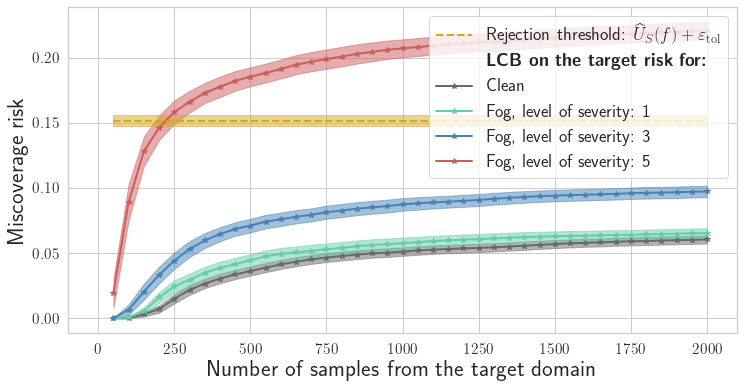

In [327]:
l1, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               clean_mean,
               color='dimgray',
               marker='*',
               label='Clean')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=clean_mean - 2 * clean_std / np.sqrt(num_of_repeats),
                 y2=clean_mean + 2 * clean_std / np.sqrt(num_of_repeats),
                 color='dimgray',
                 alpha=0.5)

l2, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               fog1_mean,
               color='mediumaquamarine',
               marker='*',
               label='Clean')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=fog1_mean - 2 * fog1_std / np.sqrt(num_of_repeats),
                 y2=fog1_mean + 2 * fog1_std / np.sqrt(num_of_repeats),
                 color='mediumaquamarine',
                 alpha=0.5)

l3, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               fog3_mean,
               color='steelblue',
               marker='*',
               label='Clean')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=fog3_mean - 2 * fog3_std / np.sqrt(num_of_repeats),
                 y2=fog3_mean + 2 * fog3_std / np.sqrt(num_of_repeats),
                 color='steelblue',
                 alpha=0.5)

l4, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               fog5_mean,
               color='indianred',
               marker='*',
               label='Clean')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=fog5_mean - 2 * fog5_std / np.sqrt(num_of_repeats),
                 y2=fog5_mean + 2 * fog5_std / np.sqrt(num_of_repeats),
                 color='indianred',
                 alpha=0.5)

l5, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               np.repeat(np.mean(source_upper_bounds), num_of_batches),
               linestyle='dashed',
               c='goldenrod')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=np.mean(source_upper_bounds) -
                 2 * np.std(source_upper_bounds) / np.sqrt(num_of_repeats),
                 y2=np.mean(source_upper_bounds) +
                 2 * np.std(source_upper_bounds) / np.sqrt(num_of_repeats),
                 color='goldenrod',
                 alpha=0.5)

plt.ylabel('Miscoverage risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)

p5, = plt.plot([0.15], marker='None', linestyle='None', label='dummy-tophead')

categories = [
    'Rejection threshold: ' +
    r'$\widehat{U}_S(f) + \varepsilon_{\mathrm{tol}}$',
    r'$\textbf{LCB on the target risk for:}$ ', 'Clean',
    'Fog, level of severity: 1', 'Fog, level of severity: 3', 'Fog, level of severity: 5'
]

leg4 = plt.legend([l5, p5, l1, l2, l3, l4],
                  categories,
                  loc=1,
                  ncol=1,
                  prop={'size': 18})  # Two columns, horizontal group labels

plt.savefig('img/cifar10_c_trained_once.pdf', bbox_inches='tight')

# average size of prediction sets

In [300]:
average_size_01_clean = list()
average_size_005_clean = list()

average_size_01_fog1 = list()
average_size_005_fog1 = list()

average_size_01_fog3 = list()
average_size_005_fog3 = list()

average_size_01_fog5 = list()
average_size_005_fog5 = list()

In [301]:
for cur_run in range(50):

    indices = np.arange(10000)
    np.random.shuffle(indices)
    cal_indices = indices[:1000]
    risk_source_indices = indices[1000:2000]
    risk_target_indices = indices[2000:3000]

    X_cal = x_clean[cal_indices]
    y_cal = y_clean[cal_indices].argmax(axis=1)
    X_risk_source = x_clean[risk_source_indices]
    y_risk_source = y_clean[risk_source_indices].argmax(axis=1)

    wrap.alpha = 0.05
    wrap.fit(X_cal, y_cal)

    #estimate miscoverage risk on the source

    # now consider the target

    cur_X = x_clean[risk_target_indices]
    cur_y = y_clean[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_005_clean += [np.mean([len(x) for x in pred_sets])]

    cur_X = x_fog1[risk_target_indices]
    cur_y = y_fog1[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_005_fog1 += [np.mean([len(x) for x in pred_sets])]

    cur_X = x_fog3[risk_target_indices]
    cur_y = y_fog3[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_005_fog3 += [np.mean([len(x) for x in pred_sets])]

    cur_X = x_fog5[risk_target_indices]
    cur_y = y_fog5[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_005_fog5 += [np.mean([len(x) for x in pred_sets])]

    wrap.alpha = 0.1
    wrap.fit(X_cal, y_cal)

    #estimate miscoverage risk on the source

    # now consider the target

    cur_X = x_clean[risk_target_indices]
    cur_y = y_clean[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_01_clean += [np.mean([len(x) for x in pred_sets])]

    cur_X = x_fog1[risk_target_indices]
    cur_y = y_fog1[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_01_fog1 += [np.mean([len(x) for x in pred_sets])]

    cur_X = x_fog3[risk_target_indices]
    cur_y = y_fog3[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_01_fog3 += [np.mean([len(x) for x in pred_sets])]

    cur_X = x_fog5[risk_target_indices]
    cur_y = y_fog5[risk_target_indices].argmax(axis=1)
    pred_sets = wrap.predict_sets(cur_X)
    average_size_01_fog5 += [np.mean([len(x) for x in pred_sets])]

In [328]:
df = pd.DataFrame()

In [329]:
df['Clean, '+r'$\beta_1$']=average_size_005_clean
df['Clean, '+r'$\beta_2$']=average_size_01_clean
df['Fog (1), '+r'$\beta_1$']=average_size_005_fog1
df['Fog (1), '+r'$\beta_2$']=average_size_01_fog1
df['Fog (3), '+r'$\beta_1$']=average_size_005_fog3
df['Fog (3), '+r'$\beta_2$']=average_size_01_fog3
df['Fog (5), '+r'$\beta_1$']=average_size_005_fog5
df['Fog (5), '+r'$\beta_2$']=average_size_01_fog5

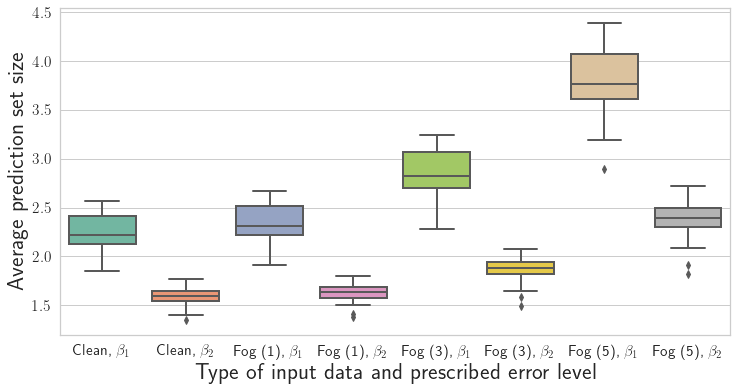

In [331]:
# plt.figure(figsize=[15,6])
sns.boxplot(data=df)
plt.ylabel('Average prediction set size', fontsize=23)
plt.xlabel('Type of input data and prescribed error level', fontsize=23)
plt.savefig('img/size_vs_alpha_and_cor.pdf', bbox_inches='tight')

In [263]:
pr_sets_05=wrap.predict_sets(x_clean[risk_target_indices][:50])

In [264]:
np.mean([len(x) for x in pr_sets_05])

2.18

In [193]:
ds_clean = tfds.as_numpy(tfds.load('cifar10_corrupted',
               split='test',
               batch_size=-1,
               as_supervised=True,
               shuffle_files=False))

ds_fog1 = tfds.as_numpy(tfds.load('cifar10_corrupted/fog_1',
               split='test',
               batch_size=-1,
               as_supervised=True,
               shuffle_files=False))

ds_fog3 = tfds.as_numpy(tfds.load('cifar10_corrupted/fog_3',
               split='test',
               batch_size=-1,
               as_supervised=True,
               shuffle_files=False))

ds_fog5 = tfds.as_numpy(tfds.load('cifar10_corrupted/fog_5',
               split='test',
               batch_size=-1,
               as_supervised=True,
               shuffle_files=False))

In [194]:
#preprocess all

x_clean = ds_clean[0].astype('float32') / 255
x_clean -= x_train_mean
y_clean = keras.utils.to_categorical(ds_clean[1], num_classes)

x_fog1 = ds_fog1[0].astype('float32') / 255
x_fog1 -= x_train_mean
y_fog1 = keras.utils.to_categorical(ds_fog1[1], num_classes)

x_fog3 = ds_fog3[0].astype('float32') / 255
x_fog3 -= x_train_mean
y_fog3 = keras.utils.to_categorical(ds_fog3[1], num_classes)

x_fog5 = ds_fog5[0].astype('float32') / 255
x_fog5 -= x_train_mean
y_fog5 = keras.utils.to_categorical(ds_fog5[1], num_classes)

In [195]:
model.evaluate(x_clean,y_clean)

313/313 [==============================] - 15s 47ms/step - loss: 0.9281 - accuracy: 0.7942


[0.9280756115913391, 0.7942000031471252]

In [196]:
model.evaluate(x_fog1,y_fog1)

313/313 [==============================] - 16s 51ms/step - loss: 0.9618 - accuracy: 0.7811


[0.9617635011672974, 0.7810999751091003]

In [197]:
model.evaluate(x_fog3,y_fog3)

313/313 [==============================] - 17s 53ms/step - loss: 1.2497 - accuracy: 0.7022


[1.249686360359192, 0.7021999955177307]

In [198]:
model.evaluate(x_fog5,y_fog5)

313/313 [==============================] - 17s 54ms/step - loss: 2.1484 - accuracy: 0.4942


[2.148421049118042, 0.4941999912261963]

In [218]:
np.where(ds_clean[1] ==5)

(array([   4,   23,   39,   41,   44,   48,   55,   57,   65,   67,   72,
          76,   83,   94,  123,  127,  130,  138,  147,  155,  156,  184,
         197,  199,  205,  206,  215,  245,  270,  278,  279,  282,  285,
         302,  307,  314,  329,  330,  359,  369,  375,  377,  383,  398,
         407,  423,  424,  431,  434,  439,  452,  457,  458,  465,  487,
         488,  491,  501,  531,  548,  550,  567,  577,  607,  616,  626,
         628,  668,  669,  679,  689,  699,  710,  712,  714,  732,  746,
         749,  764,  774,  777,  778,  782,  784,  793,  804,  817,  822,
         832,  848,  862,  873,  877,  892,  893,  915,  921,  944,  957,
         982,  995,  997,  999, 1007, 1008, 1009, 1019, 1038, 1045, 1052,
        1061, 1068, 1074, 1078, 1098, 1100, 1103, 1109, 1111, 1118, 1121,
        1127, 1129, 1136, 1155, 1156, 1162, 1167, 1185, 1187, 1190, 1201,
        1215, 1216, 1231, 1241, 1244, 1267, 1284, 1290, 1305, 1311, 1338,
        1364, 1366, 1372, 1403, 1404, 

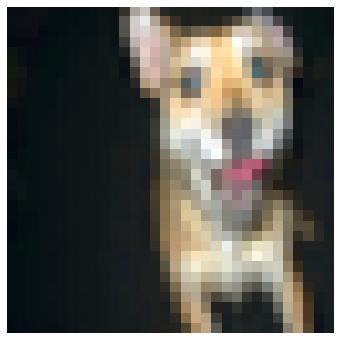

In [227]:
plt.imshow(x_clean[41]+ x_train_mean)
plt.axis('off')
plt.savefig('img/cifar10-c-clean.pdf', bbox_inches='tight')

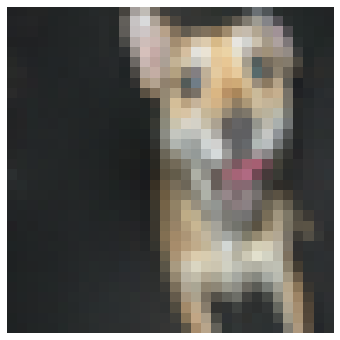

In [228]:
plt.imshow(x_fog1[41]+ x_train_mean)
plt.axis('off')
plt.savefig('img/cifar10-c-fog1.pdf', bbox_inches='tight')

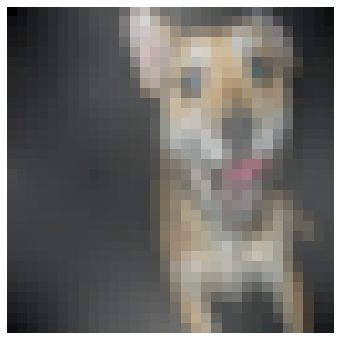

In [229]:
plt.imshow(x_fog3[41]+ x_train_mean)
plt.axis('off')
plt.savefig('img/cifar10-c-fog3.pdf', bbox_inches='tight')

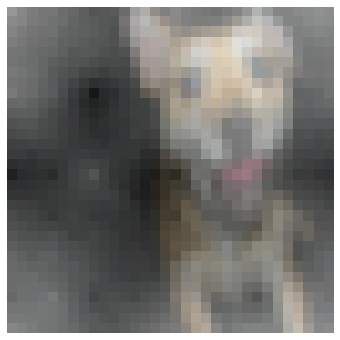

In [230]:
plt.imshow(x_fog5[41]+ x_train_mean)
plt.axis('off')
plt.savefig('img/cifar10-c-fog5.pdf', bbox_inches='tight')

In [199]:
x_clean.shape

(10000, 32, 32, 3)

In [180]:
ds_fog1[1]

array([7, 0, 6, ..., 8, 6, 0])

In [178]:
y_test.argmax(axis=1)

array([3, 8, 8, ..., 5, 1, 7])

In [181]:
x_fog1 = ds_fog1[0].astype('float32') / 255
x_fog1 -= x_train_mean

y_fog1 = keras.utils.to_categorical(ds_fog1[1], num_classes)

In [184]:
x_fog3 = ds_fog3[0].astype('float32') / 255
x_fog3 -= x_train_mean

y_fog3 = keras.utils.to_categorical(ds_fog3[1], num_classes)

In [185]:
model.evaluate(x_fog3,y_fog3)

313/313 [==============================] - 14s 43ms/step - loss: 1.2497 - accuracy: 0.7022


[1.249686360359192, 0.7021999955177307]

In [182]:
model.evaluate(x_fog1,y_fog1)

313/313 [==============================] - 14s 43ms/step - loss: 0.9618 - accuracy: 0.7811


[0.9617635011672974, 0.7810999751091003]

In [ ]:
l1, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               clean_mean,
               color='dimgray',
               marker='*',
               label='Clean')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=clean_mean - 2 * clean_std / np.sqrt(num_of_repeats),
                 y2=clean_mean + 2 * clean_std / np.sqrt(num_of_repeats),
                 color='goldenrod',
                 alpha=0.5)

l2, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               translate_mean,
               color='indianred',
               marker='*',
               label='Fog')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=translate_mean - 2 * translate_std / np.sqrt(num_of_repeats),
                 y2=translate_mean + 2 * translate_std / np.sqrt(num_of_repeats),
                 color='indianred',
                 alpha=0.5)

l3, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               zigzag_mean,
               color='steelblue',
               marker='*',
               label='Zigzag')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=zigzag_mean - 2 * fog_std / np.sqrt(num_of_repeats),
                 y2=zigzag_mean + 2 * fog_std / np.sqrt(num_of_repeats),
                 color='steelblue',
                 alpha=0.5)

l4, = plt.plot((np.arange(num_of_batches) + 1) * batch_size,
               motion_mean,
               color='mediumaquamarine',
               marker='*',
               label='Motion')

plt.fill_between((np.arange(num_of_batches) + 1) * batch_size,
                 y1=motion_mean - 2 * fog_std / np.sqrt(num_of_repeats),
                 y2=motion_mean + 2 * fog_std / np.sqrt(num_of_repeats),
                 color='mediumaquamarine',
                 alpha=0.5)

l5 = plt.axhline(tester.source_rejection_threshold,
                 linestyle='dashed',
                 c='goldenrod',
                 label='Rejection threshold: ' +
                 r'$\widehat{U}_S(f) + \varepsilon_{\mathrm{tol}}$')

plt.xlabel('Number of samples from the target domain', fontsize=23)
plt.ylabel('Misclassification risk', fontsize=23)

# plt.legend(loc='best', markerscale=1.5, prop={'size': 20})

p5, = plt.plot([0.15], marker='None', linestyle='None', label='dummy-tophead')

plt.ylabel('Misclassification risk', fontsize=23)
plt.xlabel('Number of samples from the target domain', fontsize=23)

categories = [
    'Test rejection threshold: ' +
    r'$\widehat{U}_S(f) + \varepsilon_{\mathrm{tol}}$',
    r'$\textbf{LCB on the target risk for:}$ ', 'Clean', 'Translate', 'Zigzag',
    'Motion Blur'
]

leg4 = plt.legend([l5, p5, l1, l2, l3, l4],
                  categories,
                  loc=1,
                  ncol=1,
                  prop={'size': 20})  # Two columns, horizontal group labels

# plt.ylim([-0.05,0.45])
# plt.show()
# plt.savefig('img/mnist_c_trained_once.pdf', bbox_inches='tight')